In [20]:
# Library imports.
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Local imports.
from urbansurge.fault_diagnosis import cnn_fault_diagnosis

In [21]:
# Create images and output from the random_fault_db.
fault_db_path = r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Canandaigua\Output\random_fault_db_1000.csv"
fault_db = pd.read_csv(fault_db_path)
# Drop rows with all zeros.
fault_db = fault_db.loc[(fault_db!=0).any(axis=1)]
print(fault_db.shape)

# Group by experiment.
fault_db_group = fault_db.groupby(by='Experiment')
# print(fault_db.head())
ngroup = fault_db_group.ngroups

X = np.zeros((ngroup, 1, 7, 96))
y = np.zeros((ngroup, 5))
image_cols = ['prcp', '15_depth', '16_depth', '17_depth', '18_depth', '19_depth', '20_depth']
fault_cols = ['L1_diam', 'L2_diam', 'L3_diam', 'L4_diam', 'L5_diam']
norm_vals = np.zeros((7, 1))
norm_vals[:,0] = np.array([2, 6, 6, 6, 6, 6, 6])
i = 0
for name, group in fault_db_group:
    # Reset group index.
    fault_group = group.reset_index(drop=True)
    
    # Create image array.
    img_array = np.transpose(fault_group[image_cols].to_numpy())
    
    # Normalize rows.
    img_array = img_array / norm_vals
    
    # Add to X.
    X[i, :, :, :] = img_array
    
    # Extract the fault columns.
    fault_array = fault_group.loc[0, fault_cols].to_numpy()
    fault_array = (fault_array - 3) / (5 - 3)
    
    # Add to y.
    y[i, :] = fault_array
    
    # Update counter.
    i += 1

(95904, 14)


In [22]:
# Convert your data into PyTorch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# Create a dataset from your tensors
dataset = TensorDataset(X_tensor, y_tensor)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, criterion, and optimizer
model = cnn_fault_diagnosis.SimpleCNN()
criterion = torch.nn.MSELoss()  # Mean Squared Error for regression problems
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader)}")

# Testing loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
print(f"Test Loss: {test_loss/len(test_loader)}")

Epoch 1/20, Validation Loss: 0.09003403037786484
Epoch 2/20, Validation Loss: 0.08676506727933883
Epoch 3/20, Validation Loss: 0.08593622148036957
Epoch 4/20, Validation Loss: 0.08489104807376861
Epoch 5/20, Validation Loss: 0.08392087370157242
Epoch 6/20, Validation Loss: 0.08101464956998825
Epoch 7/20, Validation Loss: 0.07789727300405502
Epoch 8/20, Validation Loss: 0.07038082927465439
Epoch 9/20, Validation Loss: 0.06617397516965866
Epoch 10/20, Validation Loss: 0.06467188969254493
Epoch 11/20, Validation Loss: 0.05645314007997513
Epoch 12/20, Validation Loss: 0.054270417988300325
Epoch 13/20, Validation Loss: 0.04832466989755631
Epoch 14/20, Validation Loss: 0.04020437709987164
Epoch 15/20, Validation Loss: 0.03414195403456688
Epoch 16/20, Validation Loss: 0.03152821771800518
Epoch 17/20, Validation Loss: 0.026430536434054373
Epoch 18/20, Validation Loss: 0.02648412957787514
Epoch 19/20, Validation Loss: 0.025970986858010293
Epoch 20/20, Validation Loss: 0.026760349050164223
Test 

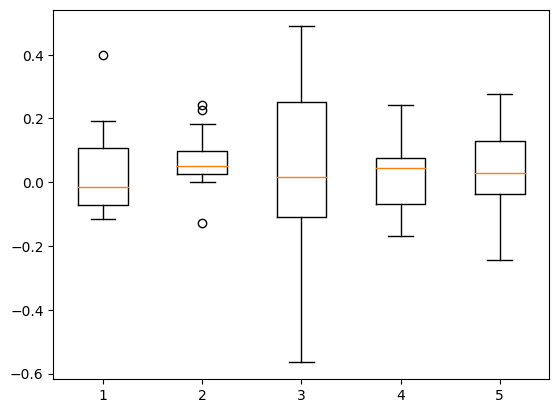

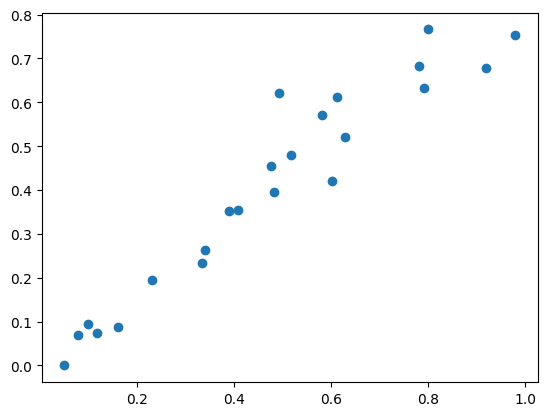

In [23]:
diff = (labels - outputs).numpy()

fig, ax = plt.subplots()
ax.boxplot(diff)

fig, ax = plt.subplots()
ax.scatter(labels[:,1], outputs[:,1])